# BSPF Event Analysis - Fingerprintting

With pressure sensor parascientific and new sensor 

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

sys.path.append("/home/andbro/andbro_python")

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

In [2]:
from functions.request_data import __request_data

In [3]:
sys.path.append("/home/andbro/Documents/ROMY/twistpy/TwistPy/")

from twistpy.utils import stransform
from twistpy.convenience import ricker
from twistpy.polarization import (
    TimeDomainAnalysis6C,
    PolarizationModel6C,
    SupportVectorMachine,
    EstimatorConfiguration,
)

## Configurations

In [4]:
config = {}

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

config['fmin'], config['fmax'] = 1.0, 10

## Load Data

In [5]:
# from functions.request_data import __request_data

In [204]:
st0 = obs.read("./event42_6c.mseed")

st = st0.copy()

tbeg = st[0].stats.starttime
tend = st[0].stats.endtime

In [7]:
st = st.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

In [8]:
st.trim(tbeg+20, tend-20)

6 Trace(s) in Stream:
PY.BSPF..HJE  | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:13:00.003700Z | 40.0 Hz, 1321 samples
PY.BSPF..HJN  | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:13:00.003700Z | 40.0 Hz, 1321 samples
PY.BSPF..HJZ  | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:13:00.003700Z | 40.0 Hz, 1321 samples
II.PFO.10.BHN | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.994538Z | 40.0 Hz, 1321 samples
II.PFO.10.BHE | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.994538Z | 40.0 Hz, 1321 samples
II.PFO.10.BHZ | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.994538Z | 40.0 Hz, 1321 samples

## S-Transform

In [9]:
from functions.makeplotStream_cwt import __makeplotStream_cwt

In [10]:
# fig = __makeplotStream_cwt(st, config);

## 6C Fingerprinting

In [11]:
from scipy.signal import hilbert, convolve
from twistpy.convenience import ricker
from twistpy.polarization import *

In [12]:
acc = st.select(station="PFO*").copy()
rot = st.select(station="BSPF").copy()

scaling_velocity = 2000

for tr in rot:
    tr.data *= scaling_velocity

In [13]:
dt = rot[0].stats.delta

# !rm /home/brotzer/TwistPy/twistpy/SVC_models/nearsurface.pkl

svm = SupportVectorMachine(name="nearsurface")

svm.train(
    wave_types=["R", "L", "P", "SV", "SH", "Noise"],
    N=10000,
    scaling_velocity=scaling_velocity,
    vp=(100, 3000),
    vp_to_vs=(1.6, 2.2),
    vl=(100, 3000),
    vr=(100, 3000),
    phi=(0, 360),
    theta=(0, 90),
    xi=(-90, 90),
    free_surface=True,
    C=1,
    kernel="rbf",
    plot_confusion_matrix=False,
)

# rot.select(channel="*Z")[0].data *= -1

window = {"window_length_seconds": 20.0 * dt, "overlap": 0.5}

analysis = TimeDomainAnalysis6C(
    traN=acc.select(channel="*N")[0],
    traE=acc.select(channel="*E")[0],
    traZ=acc.select(channel="*Z")[0],
    rotN=rot.select(channel="*N")[0],
    rotE=rot.select(channel="*E")[0],
    rotZ=rot.select(channel="*Z")[0],
    window=window,
    scaling_velocity=scaling_velocity,
    timeaxis="rel",
)

analysis.classify(svm=svm, eigenvector_to_classify=0)

classification = analysis.classification["0"]

t_windows = (analysis.t_windows)  # Positions of the sliding time windows where the classification was performed

A trained model already exists with this name and is saved at '/home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/SVC_models/nearsurface.pkl'
Nothing will be done! Please delete the file above if you want to re-train this model.
Computing covariance matrices...
Covariance matrices computed!
Performing eigen-decomposition of covariance matrices...
Eigenvectors and eigenvalues have been computed!
Wave type classification in progress...
Wave types have been classified!


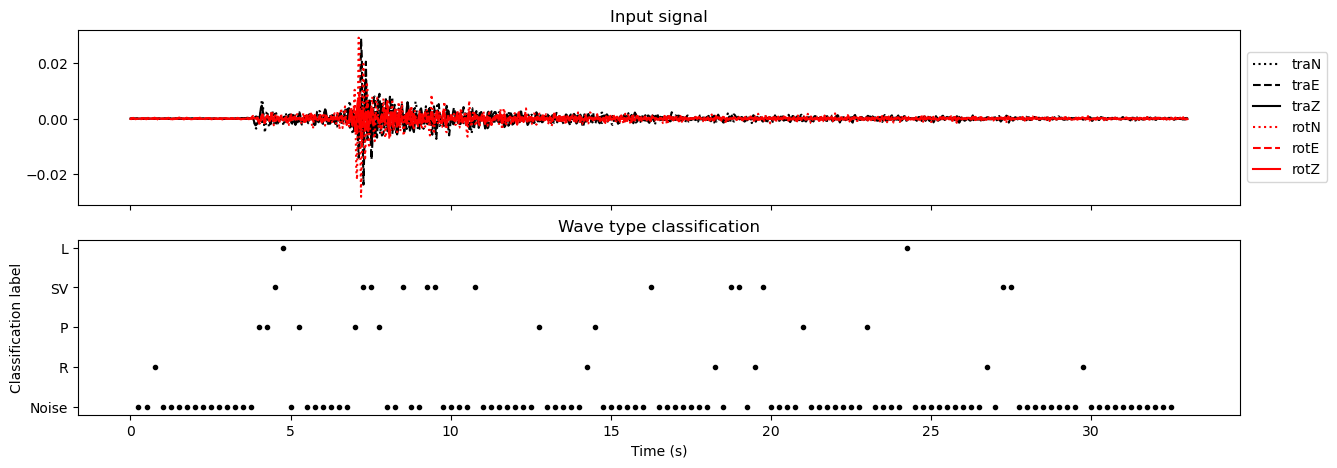

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

t = acc.select(channel="*N")[0].times()

ax1.plot(t, acc.select(channel="*N")[0].data, "k:", label="traN")
ax1.plot(t, acc.select(channel="*E")[0].data, "k--", label="traE")
ax1.plot(t, acc.select(channel="*Z")[0].data, "k", label="traZ")
ax1.plot(t, rot.select(channel="*N")[0].data, "r:", label="rotN")
ax1.plot(t, rot.select(channel="*E")[0].data, "r--", label="rotE")
ax1.plot(t, rot.select(channel="*Z")[0].data, "r", label="rotZ")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax1.set_title("Input signal")

ax2.plot(t_windows, classification, "k.")
ax2.set_title("Wave type classification")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Classification label")

plt.show();

In [15]:
window = {"number_of_periods": 1, "frequency_extent": 2}

analysis_tf = TimeFrequencyAnalysis6C(
    traN=acc.select(channel="*N")[0],
    traE=acc.select(channel="*E")[0],
    traZ=acc.select(channel="*Z")[0],
    rotN=rot.select(channel="*N")[0],
    rotE=rot.select(channel="*E")[0],
    rotZ=rot.select(channel="*Z")[0],
    window=window,
    timeaxis="rel",
)

analysis_tf.classify(svm=svm, eigenvector_to_classify=0)

classification_tf = analysis_tf.classification["0"]


Computing covariance matrices...
Covariance matrices computed!
Performing eigen-decomposition of covariance matrices...
Eigenvectors and eigenvalues have been computed!
Wave type classification in progress...
Wave types have been classified!


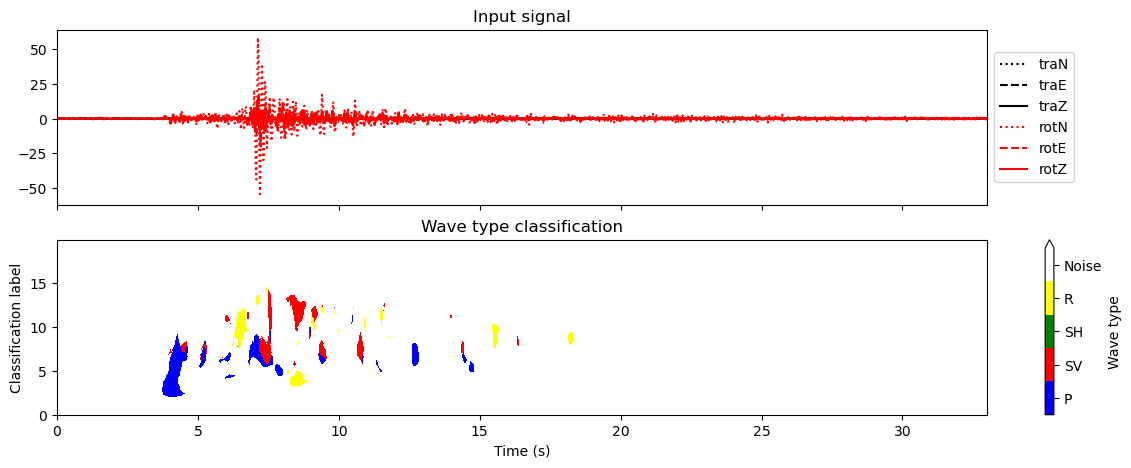

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

t = acc.select(channel="*N")[0].times()

ax1.plot(t, acc.select(channel="*N")[0].data, "k:", label="traN")
ax1.plot(t, acc.select(channel="*E")[0].data, "k--", label="traE")
ax1.plot(t, acc.select(channel="*Z")[0].data, "k", label="traZ")
ax1.plot(t, rot.select(channel="*N")[0].data*scaling_velocity, "r:", label="rotN")
ax1.plot(t, rot.select(channel="*E")[0].data*scaling_velocity, "r--", label="rotE")
ax1.plot(t, rot.select(channel="*Z")[0].data*scaling_velocity, "r", label="rotZ")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax1.set_title("Input signal")

ax2.set_title("Wave type classification")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Classification label")
analysis_tf.plot_classification(ax2)

pos0 = ax1.get_position()
pos = ax2.get_position()
ax1.set_position([pos0.x0, pos0.y0, pos.width, pos.height])


plt.show();

## 6C Polarization

In [479]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()


# rot.select(channel="*N")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*Z")[0].data *= -1
acc.select(channel="*Z")[0].data *= -1
acc.select(channel="*N")[0].data *= -1
acc.select(channel="*E")[0].data *= -1

fmin, fmax = 0.5, 1.0

acc = acc.detrend("simple").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=8, zerophase=True)
rot = rot.detrend("simple").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=8, zerophase=True)

acc = acc.trim(acc[0].stats.starttime+10, acc[0].stats.endtime-10)
rot = rot.trim(rot[0].stats.starttime+10, rot[0].stats.endtime-10)

scaling_velocity = 1500

for tr in rot:
    tr.data *= scaling_velocity



In [480]:

!rm /home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/SVC_models/test_love_wave.pkl

svm = SupportVectorMachine(name="test_love_wave")


In [481]:
svm.train(
    wave_types=["R", "P", "SV", "L", "Noise"],
    N=5000,
    scaling_velocity=scaling_velocity,
    vp=(100, 5000),
    vp_to_vs=(1.7, 2.4),
    vl=(100, 5000),
    vr=(100, 5000),
    phi=(0, 360),
    theta=(0, 90),
    xi=(-90, 90),
    free_surface=True,
    C=1,
    kernel="rbf",
    plot_confusion_matrix=False,

)

Generating random polarization models for training! 

Training Support Vector Machine!
Training successfully completed. Model score on independent test data is '0.9496'!
Model has been saved as '/home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/SVC_models/test_love_wave.pkl'!'


In [482]:
window = {"window_length_seconds": 20.0 * dt, "overlap": 1.0}

analysis = TimeDomainAnalysis6C(
    traN=acc.select(channel="*N")[0],
    traE=acc.select(channel="*E")[0],
    traZ=acc.select(channel="*Z")[0],
    rotN=rot.select(channel="*N")[0],
    rotE=rot.select(channel="*E")[0],
    rotZ=rot.select(channel="*Z")[0],
    window=window,
    scaling_velocity=scaling_velocity,
    timeaxis="rel",
)

Computing covariance matrices...
Covariance matrices computed!


Performing eigen-decomposition of covariance matrices...
Eigenvectors and eigenvalues have been computed!
Wave type classification in progress...
Wave types have been classified!
Computing wave parameters...


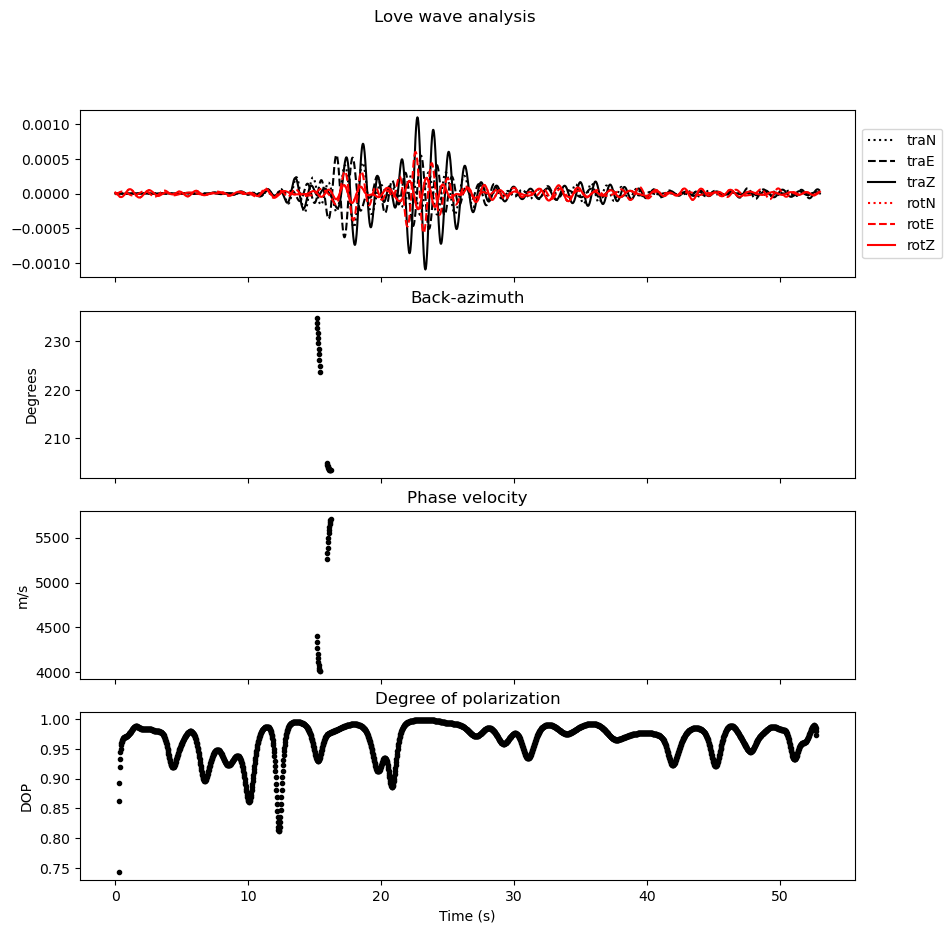

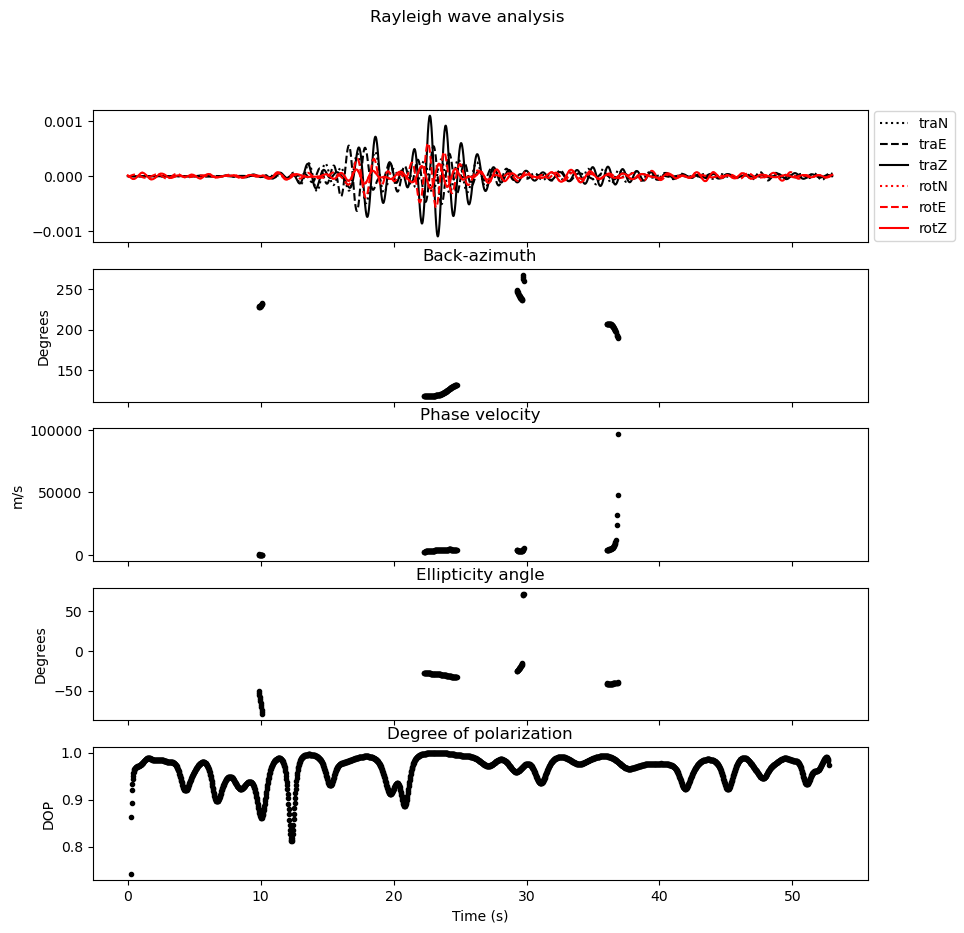

In [483]:
analysis.classify(svm=svm, eigenvector_to_classify=0)

classification = analysis.classification["0"]

t_windows = (analysis.t_windows)  # Positions of the sliding time windows where the classification was performed

#  Wave parameter estimation

est = EstimatorConfiguration(
                            wave_types=["L", "R"],
                            method="ML",
                            scaling_velocity=scaling_velocity,
                            use_ml_classification=True,
                            svm=svm,
)

analysis.polarization_analysis(estimator_configuration=est)

analysis.plot(estimator_configuration=est, dop_clip=0.01)
